<a href="https://colab.research.google.com/github/awadell1/MLOnAGooseberryBush/blob/master/src/Data_Preprocessing_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import re
import string
from tqdm.notebook import tqdm #create a progress bar
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
import io
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


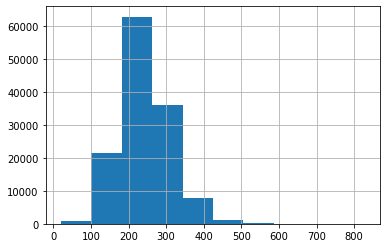

In [3]:
#load the data
raw_df=pd.read_csv('/content/drive/My Drive/24787 Group Project  /Data/winemag-data-130k-v2.csv',index_col=0)
#get all the description but the last one to make the next step easier
#the last description is added back 2 cells later
raw_data=raw_df[['description']]
raw_data['Length']=raw_data['description'].str.len()
raw_data['description'].str.len().hist()

#### I was wrong about deleting the double quotation mark. It turns out it was because I put the double quotation mark at the wrong place in the filter. And also, now the issue of '\xad' is fixed as well. No need to explicitly get rid of it.

##### This following function is a helper function to check whether a certain vocab is in the filtered dictionary given a customized filter.

In [5]:
def check_word(string_to_find, filter_to_use, df):
  #this function will check whether a certain word is in the description after you provide the filters.
    all_words = []
    count=0
    for i, row in tqdm(df.iterrows()):
            temp=text_to_word_sequence(row[0],filters=filter_to_use)
            all_words.extend(temp)
            if string_to_find in temp:
               count+=1
               print("'"+string_to_find+"'"+" appears in the",str(i)+"th line in the description")
    if count == 0:
       print("'"+string_to_find+"'"+" is not in the cleaned up text.")

In [6]:
#examples (!!!remember to update the filters if you find a new text to get rid off!!!)
check_word(string_to_find='"loin"',filter_to_use='­­"…–â€˜‘’—!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”',df=raw_data)
check_word(string_to_find='intensfiy',filter_to_use='­­"…–â€˜‘’—!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”',df=raw_data)


'"loin"' is not in the cleaned up text.


'intensfiy' appears in the 92247th line in the description



##### This function will clean up the text and create a word_count dataframe. Also show the plot if the plotter option is turned on

In [4]:
def text_clean_up(dataframe,filter_to_use,plotter):
    all_words = []
    for i, row in tqdm(dataframe.iterrows()):
            all_words.extend(text_to_word_sequence(row[0],filters=filter_to_use))
    word_counts = pd.Series(all_words).value_counts()
    if plotter == True:
        plt.figure(figsize=(12,6))
        print('20 most common tokens')
        word_counts.head(20).iloc[::-1].plot.barh()
        plt.xlabel('# of occurences')
        plt.show()

        plt.figure(figsize=(12,6))
        print('20 least common tokens')
        word_counts.tail(20).iloc[::-1].plot.barh()
        plt.xlabel('# of occurences')
        plt.show()
    return all_words, word_counts


20 most common tokens


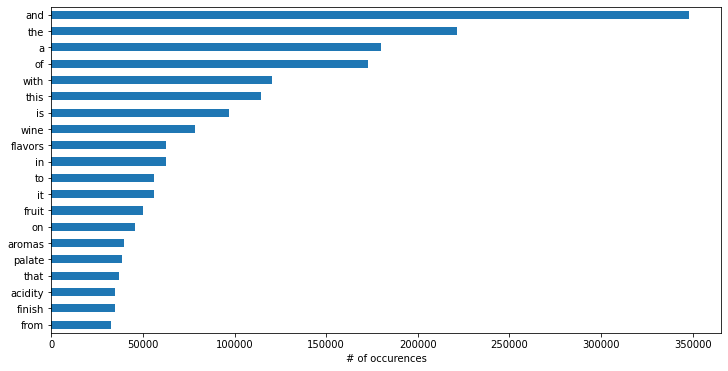

20 least common tokens


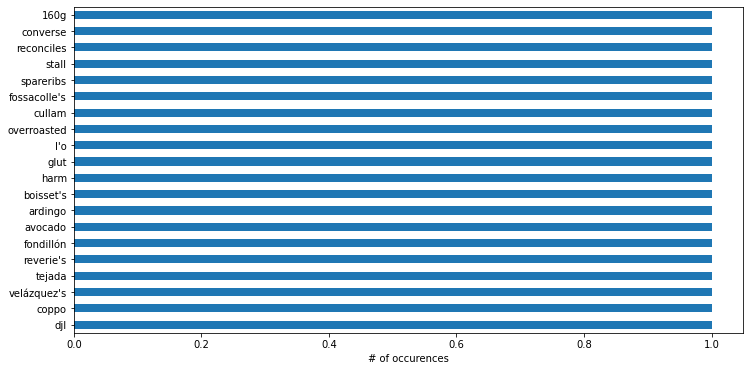

In [5]:
##(!!!remember to update the filters if you find a new text to get rid off!!!)
all_words, word_counts=text_clean_up(dataframe=raw_data,filter_to_use='­­"…–â€˜‘’—!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”',plotter=True)

In [9]:
print('The number of vocab only appears once in the descriptions: '+str(sum(word_counts==1)))
print('The ratio of vocab only appears once in the description to the total vocab: '+str(sum(word_counts==1)/len(word_counts)))

The number of vocab only appears once in the descriptions: 11798
The ratio of vocab only appears once in the description to the total vocab: 0.3557042932947419


In [11]:
def word_counts_saver(data,name):
   #save the word_counts if neccessary
    word_counts=pd.DataFrame(data)
    path = '/content/drive/My Drive/24787 Group Project  /Data/'+name+'.csv'
    word_counts.to_csv(path)

In [12]:
word_counts_saver(data=word_counts,name='word_counts_newest')

In [13]:
#a helperfunction to print out n items of dictionary
from itertools import islice
 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [14]:
def dict_generator(data):
    vocab = pd.DataFrame(data).index.values
    vocab=vocab.tolist()
    w2ind={}
    w2ind[''] = 0 #for padding
    ind2w={}
    ind2w[0]= '' #for padding
    for i,word in enumerate(vocab):
        w2ind[word] = i+1
        ind2w[i+1] = word
    return w2ind, ind2w

In [15]:
word2ind,ind2word=dict_generator(data=word_counts)
print('word2ind_dict',take(10, word2ind.items()))
print('ind2word_dict',take(10, ind2word.items()))

word2ind_dict [('', 0), ('and', 1), ('the', 2), ('a', 3), ('of', 4), ('with', 5), ('this', 6), ('is', 7), ('wine', 8), ('flavors', 9)]
ind2word_dict [(0, ''), (1, 'and'), (2, 'the'), (3, 'a'), (4, 'of'), (5, 'with'), (6, 'this'), (7, 'is'), (8, 'wine'), (9, 'flavors')]


#### create data for w2v model. This function also separates each sentence by spliting '.'

In [16]:
def sentence_to_indices(dataframe,filter_to_use,w2ind):
    sentences_num=[]
    for _, row in tqdm(raw_data.iterrows()):
        temp_sentences=row[0].split('.')
        temp_sentences=list(filter(None, temp_sentences))
        for _, sentence in enumerate(temp_sentences):
            tokens=text_to_word_sequence(sentence,filters=filter_to_use)
            temp_mem=[w2ind[word] for word in tokens]
            sentences_num.append(temp_mem)
    return sentences_num

In [17]:
##(!!!remember to update the filters if you find a new text to get rid off!!!)
sentences_num=sentence_to_indices(dataframe=raw_data,filter_to_use='­­"…–â€˜‘’—!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”',w2ind=word2ind)
print("the number of sentences is "+str(len(sentences_num)))
max_sentence_length = max([len(seq) for seq in sentences_num])
print("the maximum length of the sentence is "+str(max_sentence_length))


the number of sentences is 356461
the maximum length of the sentence is 66


In [18]:
def sentence_save(data,name,ind2w):
    path_to_file = "/content/drive/My Drive/24787 Group Project  /Data/"+name+".txt"
    f= open(path_to_file,"w")
    for i in range(len(data)):
        text = [ind2w[j] for j in data[i]]
        for text0 in text:
            f.write(text0+'\t')
        f.write('\n')
    f.close()

In [19]:
sentence_save(data=sentences_num,name='description_sentence_newest',ind2w=ind2word)

In [20]:
def sentence_printout(path):
    #just to demonstrate the txt file (the first ten sentence)
    with open(path) as f: 
        lines = f.read().splitlines()
    for line in lines[:10]:
        print(line)
    f.close()

In [22]:
sentence_printout(path= "/content/drive/My Drive/24787 Group Project  /Data/description_sentence_newest.txt")

aromas	include	tropical	fruit	broom	brimstone	and	dried	herb	
the	palate	isn't	overly	expressive	offering	unripened	apple	citrus	and	dried	sage	alongside	brisk	acidity	
this	is	ripe	and	fruity	a	wine	that	is	smooth	while	still	structured	
firm	tannins	are	filled	out	with	juicy	red	berry	fruits	and	freshened	with	acidity	
it's	already	drinkable	although	it	will	certainly	be	better	from	2016	
tart	and	snappy	the	flavors	of	lime	flesh	and	rind	dominate	
some	green	pineapple	pokes	through	with	crisp	acidity	underscoring	the	flavors	
the	wine	was	all	stainless	steel	fermented	
pineapple	rind	lemon	pith	and	orange	blossom	start	off	the	aromas	
the	palate	is	a	bit	more	opulent	with	notes	of	honey	drizzled	guava	and	mango	giving	way	to	a	slightly	astringent	semidry	finish	


In [23]:
input_sequences = np.array(pad_sequences(sentences_num, maxlen=max_sentence_length, padding='pre'))

In [24]:
for seq in input_sequences[:2]:
  print(f"{seq} \n => \n {[ind2word[i] for i in seq]}")

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   15  875  202   13 1979 3599    1   88  105] 
 => 
 ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'aromas', 'include', 'tropical', 'fruit', 'broom', 'brimstone', 'and', 'dried', 'herb']
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     2    16   908  1028   927

### This is a demonstration of spell corrector.
#### Go to this github repos to find the code: https://github.com/makcedward/nlp . Download the code and upload the folder name "aion" to the Colad Notebook folder. Once you are done you can run the following code to import it.
##### This method is not the optimal(Let me know if you know how to do the better upload, install and import method)

#### I tried a couple of times to permanently install it on the colab. But then the library doesn't work as expected. So I just gave up. Now we need to install it every time when running the notebook.

In [6]:
import sys, os
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)
!pip install --target=$nb_path aion

  Created wheel for aion: filename=Aion-0.1-cp36-none-any.whl size=942 sha256=2e10c28cee9a8cccfe39d877cf2fca45ef046e20b0049f5687db8ee9ea111af6
  Stored in directory: /root/.cache/pip/wheels/07/57/2b/8d23b69d0bfbba62ef07de99bcccdad45ee152aed5792978eb
Successfully built aion


In [7]:
#for some reason you can't combine these 2 cells(the above one and this one)
#otherwise the spellcorrector will not work as expected
!pip install symspellpy

     |████████████████████████████████| 2.6MB 5.4MB/s 


In [8]:
from collections import Counter
corpus = Counter(all_words)
from aion.util.spell_check import SpellCorrector
spell_corrector = SpellCorrector(dictionary=corpus, verbose=1)
spell_corrector.correction('intensfiy')

Known Result:  {'intensfiy'}
Edit1 Result:  {'intensify', 'intensfiy'}
Edit2 Result:  {'intensely', 'intensly', 'intensfiy', 'intensity', 'intensitiy', 'intensify'}


'intensfiy'

In [13]:
spell_corrector.correction('guardia')

Known Result:  {'guardia'}
Edit1 Result:  {'guardian', 'guardia', 'guarda'}
Edit2 Result:  {'guardian', 'guards', 'guarding', 'guarda', 'guard', 'guarded', 'guardia', 'guardiola', 'garcia', 'garda', 'gandia'}


'guardia'